In [336]:
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container { width: 95%;} div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style> """))

#%matplotlib inline
%matplotlib notebook

import matplotlib 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import seaborn as sns
import os
import io
import datetime
from dateutil import parser, rrule
from datetime import datetime, time, date
import time
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
import requests
import scipy
import tensorflow as tf
import re

# import function from current working directory
from getRainfallData import getRainfallData


pd.set_option('display.max_rows', 500)    
np.set_printoptions(suppress=True)

# Pull UH-ASPA data off of my GitHub site
note, reflects ost recent update of processed data, not raw data

In [335]:
url = "https://raw.githubusercontent.com/cshuler/ASPA-UH_Integrated_Modeling_Framework/master/ASPA-UH_Wx_REPO/workspace/QA_All_merged.csv"
save_to = os.path.join("..", 'Data', "All_consolodated_Q_m3ps.csv")

r = requests.get(url, allow_redirects=True)
open(save_to, 'wb').write(r.content)

16346953

#### get the data into memory

In [166]:
rawdata = pd.read_csv(save_to ,index_col=1,parse_dates=True)   # read in data
rawdata = rawdata.drop(rawdata.columns[0], axis=1)             # get rid of pesky index column

param_list =  ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'RNF_in', 'WND_deg', 'WNS_mph']

param_dic = {}
for q in param_list: 
    r = re.compile(".*{}".format(q))  
    Col_list = list(filter(r.match, list(rawdata.columns)))
    tempframe = rawdata[Col_list]
    param_dic[q] = tempframe
    
# resample the rainfall to hourly values using a sum method
param_dic['RNF_in'] = param_dic['RNF_in'].resample('D').sum()     # subsample the 15 min data into daily values
# resample all others to hourly values using a average method
ave_param_list = ['SRD_wpm2', 'HMD_pct', 'TMP_F', 'WND_deg', 'WNS_mph'] 
for i in ave_param_list:
    param_dic[i] = param_dic[i].resample('D').mean()     # subsample the 15 min data into daily values

# Exoloratory Plot  All the datasets 
for i in param_list: 
    param_dic[i].plot(subplots=True, figsize=(12, 8))
    plt.tight_layout()
    plt.legend(loc='best')  

# Tula Data
From Tula weather station, pre-downloaded and living in a file folder, Tula site is: https://www.esrl.noaa.gov/gmd/obop/smo/

### careful, long run time

In [293]:
# processing Tula data into a single dataframe
path_Tula_data = os.path.join("..", "Data", 'External_weather_data', 'Tula', "Met")

trash_cols = ['SITE CODE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'WND', 'WNS_mpsec', 'WND_STEADY', 'BAR_p', 'TMP_2m', 'TMP_10m', 'TMP_top', 'HMD', 'PRECIP_mm']
want_cols = ['Date', 'PRECIP_mm', 'HMD', 'TMP_2m', 'WND', 'WNS_mpsec']

files = os.listdir(path_Tula_data)                     # get all file names in the folder
na_values = ['-99', '-9', '-999', '-99.9', '-999.9']   #values to turn into NaN 
temp_data =  pd.DataFrame(columns=trash_cols)          # empty container for concat

for i in files: 
    q = pd.read_csv(os.path.join(path_Tula_data, i), delim_whitespace=True, names=trash_cols, na_values=na_values) # open each file
    temp_data = pd.concat([temp_data, q], axis=0)     # stick em all together

temp_data['Date'] = temp_data[['YEAR', 'MONTH', 'DAY', 'HOUR']].apply(lambda x : datetime.datetime(*x),axis = 1)  # make the date a date
tula_data2 = temp_data[want_cols].set_index("Date") 

# Now resampling data into neeed formats   this is set up for daily resampling 
tula_data2['Tmp_max'] = tula_data2['TMP_2m']                   # just make the columns get ready for resampling
tula_data2['Tmp_min'] = tula_data2['TMP_2m']                  # just make the columns get ready for resampling
tula_data2 = tula_data2.rename(columns={'TMP_2m': 'TMP_ave'})  # just make the columns get ready for resampling

tula_data_rn = tula_data2['PRECIP_mm'].resample('D').sum()      # resample the rain different than the other columns
tula_data_tmax = tula_data2['Tmp_max'].resample('D').max()      # resample the tmax different than the other columns
tula_data_tmin = tula_data2['Tmp_min'].resample('D').min()      # resample the tmin different than the other columns
tula_data_others = tula_data2[['HMD', 'TMP_ave', 'WND', 'WNS_mpsec']].resample('D').mean()   
Tula_data = tula_data_others.join(tula_data_rn)                 #merge tehm back together
Tula_data = Tula_data.join(tula_data_tmin)                 #merge tehm back together
Tula_data = Tula_data.join(tula_data_tmax)                 #merge tehm back together

# unit conversions
Tula_data['RNF_in'] =  Tula_data['PRECIP_mm'].apply(lambda x: x*0.0393701)     # convert rain in mm to rain in inches
Tula_data['TMP_ave_F'] =  Tula_data['TMP_ave'].apply(lambda x: x*1.8 + 32)     # convert rain in mm to rain in inches
Tula_data['WNS_mph'] =  Tula_data['WNS_mpsec'].apply(lambda x: x*2.23694)     # convert rain in mm to rain in inches
del Tula_data['WNS_mpsec']; del Tula_data['TMP_ave']; del Tula_data['PRECIP_mm']; 

# this block is to deal with the separate solar radiation (SLR )files
Path_go_SLR = os.path.join("..", "Data", 'External_weather_data', 'Tula', 'Slr') 

trash_cols = ['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'DIRECT', 'DIFFUSE2', 'D_GLOBAL', 'D_IR', 'Zenith']
want_cols = ["Date", "DIRECT"]

SLR_files = os.listdir(Path_go_SLR)                     # get all file names in the folder
na_values = ['-99', '-9', '-999', '-99.9', '-999.9']   #values to turn into NaN 

temp_data =  pd.DataFrame(columns=trash_cols)          # empty container for concat
for i in SLR_files: 
    q = pd.read_csv(os.path.join(Path_go_SLR, i), delim_whitespace=True, skiprows= range(0,4), names=trash_cols,  na_values=na_values) # open each file     
    temp_data = pd.concat([temp_data, q], axis=0)     # stick em all together

temp_data['Date'] = temp_data[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN']].apply(lambda x : datetime.datetime(*x),axis = 1)  # make the date a date
tula_SLR2 = temp_data[want_cols].set_index("Date") 
tula_data_SLR = tula_SLR2['DIRECT'].resample('D').mean()      # resample the rain different than the other columns

Tula_data = Tula_data.join(tula_data_SLR)        
Tula_data = Tula_data.rename(columns={'DIRECT': 'SLR_wpm2'})

#Tula_data = Tula_data.loc["2015-01-01 01:00:00":"2019-10-01 01:00:00"]

<IPython.core.display.Javascript object>


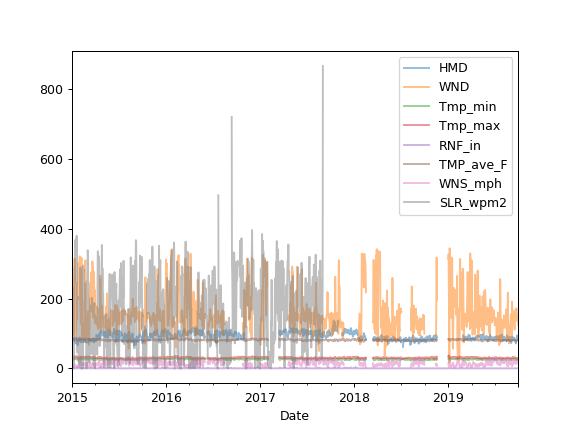

HMD         WND  Tmp_min  Tmp_max    RNF_in  TMP_ave_F  \
Date                                                                       
2015-01-01  86.416667  241.250000     25.4     28.7  0.944882    80.8400   
2015-01-02  85.166667  128.500000     26.4     32.7  0.118110    82.1750   
2015-01-03  84.000000  150.291667     24.5     31.4  0.157480    81.0425   
2015-01-04  83.000000  127.333333     26.8     33.8  0.039370    83.0075   
2015-01-05  84.666667   97.166667     25.9     33.0  2.401576    82.4525   
...               ...         ...      ...      ...       ...        ...   
2019-09-26  92.125000  138.291667     25.3     29.9  0.000000    79.8875   
2019-09-27  86.375000  133.750000     26.3     29.7  0.000000    81.3350   
2019-09-28  84.166667  148.625000     25.6     29.6  0.000000    81.1325   
2019-09-29  81.750000  155.166667     25.8     30.3  0.000000    81.3800   
2019-09-30  82.450000  124.450000     26.6     30.0  0.000000    81.5450   

              WNS_mph    SLR_wpm2  
Date                               
2015-01-01  12.275208    0.503584  
2015-01-02   5.638953  154.619610  
2015-01-03  13.645334   66.635422  
2015-01-04   9.954383  231.834870  
2015-01-05   9.861177  200.407119  
...               ...         ...  
2019-09-26  17.159194         NaN  
2019-09-27  20.906068         NaN  
2019-09-28  23.991182         NaN  
2019-09-29  20.290910         NaN  
2019-09-30  24.617525         NaN  

[1734 rows x 8 columns]

In [294]:
# plot 
Tula_data.plot(alpha=.5)
Tula_data

# Daily Airport Data
 from http://scacis.rcc-acis.org/ for daily data  and also from: https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:61705/detail for hourly data


In [291]:
path_PPG_data = os.path.join("..", "Data", 'External_weather_data', 'PPG', "daily")                # open dataset
PPG = pd.read_csv(os.path.join(path_PPG_data, 'PPG-2000-oct2-19-daily.csv'), usecols = [2, 5, 13, 18, 19]) #  ,21])  will give wind directions
PPG['DATE'] = pd.to_datetime(PPG['DATE'], errors='coerce')
PPG = PPG.set_index('DATE')

# Now Hourly Airport Data  (junkshow) for needed only for RH data, not in the daily file for some reason, 
path_PPG_data_RH = os.path.join("..", "Data", 'External_weather_data', 'PPG', "hourly")                # open dataset
a = pd.read_csv(os.path.join(path_PPG_data_RH, 'PPG_2010-2019(oct)-hourly.csv'), usecols = [1,2,3, 48])  # cut out rando columns
a = a[a['REPORT_TYPE'] == 'FM-15']                                       # apparently the hourly data we want is codes as FM-15 Data
a['DATE'] = pd.to_datetime(a['DATE'], errors='coerce')                   # string date to real date
a['DATE'] = a['DATE'].dt.round('H')                                      # timestamps are in rando near hour times, round to the hour
a = a.set_index('DATE')
del a['REPORT_TYPE']
del a['SOURCE']
a = a.apply(pd.to_numeric, errors='coerce')                       # convert all columns of DataFrame to floats, turns any non-numerics to nan

#  resample to daily values 
PPG_RH_dat = a.resample('D').mean()      # resample the rain different than the other columns
PPG_RH_dat.rename(columns={'HourlyRelativeHumidity': 'RH_pct'}, inplace=True)      # rename column


PPG = PPG.join(PPG_RH_dat)                 #merge the datasets together


#PPG = PPG.loc["2015-01-01 01:00:00":"2019-09-01 01:00:00"]


<IPython.core.display.Javascript object>


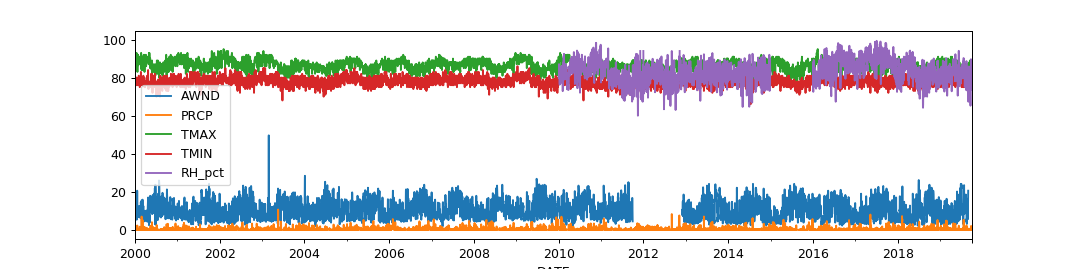

AWND  PRCP  TMAX  TMIN     RH_pct
DATE                                         
2000-01-01  7.61  0.32  90.0  77.0        NaN
2000-01-02  7.61  0.00  92.0  79.0        NaN
2000-01-03  5.59  0.25  91.0  77.0        NaN
2000-01-04  6.71  0.00  93.0  78.0        NaN
2000-01-05  5.59  0.00  93.0  80.0        NaN
...          ...   ...   ...   ...        ...
2019-09-29   NaN  0.03  87.0  80.0  78.521739
2019-09-30   NaN  0.00   NaN  80.0  75.954545
2019-10-01   NaN  0.00  88.0  80.0  73.916667
2019-10-02   NaN  0.00  88.0  78.0  74.500000
2019-10-03   NaN  0.00  88.0  78.0  73.666667

[7216 rows x 5 columns]

In [290]:
# Plot
PPG.plot(figsize =(12,3))
PPG

<IPython.core.display.Javascript object>


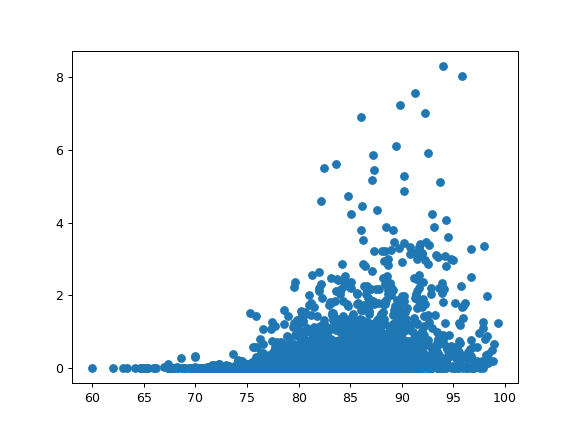

In [288]:
fig, ax = plt.subplots()
plt.scatter(PPG['RH_pct'],PPG['PRCP'])

# Processing historical ASCC data obtained from Mark

In [ ]:

ASCC_All = pd.read_csv(os.path.join(path_ASCC_data), parse_dates=[['Date', 'Time']],  keep_date_col=True)
ASCC_rain = ASCC_All[['Date_Time','Rain']].copy()                          # pull out just the rain column
ASCC_rain['Rain'] = pd.to_numeric(ASCC_rain['Rain'], errors='coerce')

ASCC_rain['ASCC_RNF'] =  ASCC_rain['Rain'].apply(lambda x: x*0.0393701)     # convert rain in mm to rain in inches

ASCC_day_rain = ASCC_rain.set_index('Date_Time').resample('D').sum()     # sum the rainfall by days
ASCC_day_rain_frame = pd.DataFrame(ASCC_day_rain)                        # make the series into a DF
ASCC_rain_daily = ASCC_day_rain_frame.reset_index(drop=False)            # pull the date index to a date column
ASCC_rain_daily.rename(columns={'Date_Time': 'Date'}, inplace=True)      # rename column
del ASCC_rain_daily['Rain']                                              # del mm rainfall column



#######  OK working on this now

# Pull Data from our ASCC station off weather underground 
Using this https://www.shanelynn.ie/analysis-of-weather-data-using-pandas-python-and-seaborn/

In [331]:


def getRainfallData(station, day, month, year):
    """
    Function to return a data frame of minute-level weather data for a single Wunderground PWS station.
    
    Args:
        station (string): Station code from the Wunderground website
        day (int): Day of month for which data is requested
        month (int): Month for which data is requested
        year (int): Year for which data is requested
    
    Returns:
        Pandas Dataframe with weather data for specified station and date.
    """
    url = "http://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID={station}&day={day}&month={month}&year={year}&graphspan=day&format=1"
    full_url = url.format(station=station, day=day, month=month, year=year)
    # Request data from wunderground data
    response = requests.get(full_url, headers={'User-agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})
    data = response.text
    # remove the excess <br> from the text data
    data = data.replace('<br>', '')
    # Convert to pandas dataframe (fails if issues with weather station)
    try:
        dataframe = pd.read_csv(io.StringIO(data), index_col=False)
        dataframe['station'] = station
    except Exception as e:
        print("Issue with date: {}-{}-{} for station {}".format(day,month,year, station))
        return None
    return dataframe    

In [333]:
# Generate a list of all of the dates we want data for
start_date = "2015-08-01"
end_date = "2018-08-01"
start = parser.parse(start_date)
end = parser.parse(end_date)
dates = list(rrule.rrule(rrule.DAILY, dtstart=start, until=end))

# Create a list of stations here to download data for
stations = ["IWESTERN499"]
# Set a backoff time in seconds if a request fails
backoff_time = 10
data = {}

# Gather data for each station in turn and save to CSV.
for station in stations:
    print("Working on {}".format(station))
    data[station] = []
    for date in dates:
        # Print period status update messages
        if date.day % 10 == 0:
            print("Working on date: {} for station {}".format(date, station))
        done = False
        while done == False:
            try:
                weather_data = getRainfallData(station, date.day, date.month, date.year)
                done = True
            except ConnectionError as e:
                # May get rate limited by Wunderground.com, backoff if so.
                print("Got connection error on {}".format(date))
                print("Will retry in {} seconds".format(backoff_time))
                time.sleep(10)
        # Add each processed date to the overall data
        data[station].append(weather_data)
    Big_dataframe = pd.concat(data[station])  # .to_csv("data/{}_weather.csv".format(station))


Working on IWESTERN499
Working on date: 2015-08-10 00:00:00 for station IWESTERN499
Working on date: 2015-08-20 00:00:00 for station IWESTERN499
Working on date: 2015-08-30 00:00:00 for station IWESTERN499
Working on date: 2015-09-10 00:00:00 for station IWESTERN499
Issue with date: 13-9-2015 for station IWESTERN499
Working on date: 2015-09-20 00:00:00 for station IWESTERN499
Working on date: 2015-09-30 00:00:00 for station IWESTERN499
Issue with date: 30-9-2015 for station IWESTERN499
Issue with date: 3-10-2015 for station IWESTERN499
Issue with date: 4-10-2015 for station IWESTERN499
Issue with date: 6-10-2015 for station IWESTERN499
Working on date: 2015-10-10 00:00:00 for station IWESTERN499
Working on date: 2015-10-20 00:00:00 for station IWESTERN499
Working on date: 2015-10-30 00:00:00 for station IWESTERN499
Working on date: 2015-11-10 00:00:00 for station IWESTERN499
Working on date: 2015-11-20 00:00:00 for station IWESTERN499
Issue with date: 27-11-2015 for station IWESTERN499

C:\Users\cshuler\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

